# BEE 4750 Homework 4: Linear Programming and Capacity Expansion

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 11/07/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to formulate and solve a resource allocation
    problem using linear programming.
-   Problem 2 asks you to formulate, solve, and analyze a standard
    generating capacity expansion problem.
-   Problem 3 (5750 only) asks you to add a CO<sub>2</sub> constraint to
    the capacity expansion problem and identify changes in the resulting
    solution.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\trent\Desktop\BEE4750\hw4-trent-ali-1`
   Installed ArgCheck ─────── v2.3.0
   Installed MarkdownTables ─ v1.1.0
   Installed DisplayAs ────── v0.1.6
Precompiling project...
  ✓ ArgCheck
  ✓ DisplayAs
  ✓ MarkdownTables
  3 dependencies successfully precompiled in 15 seconds. 188 already precompiled.


In [2]:
using JuMP
using HiGHS
using DataFrames
using Plots
using Measures
using CSV
using MarkdownTables

## Problems (Total: 50/60 Points)

### Problem 1 (20 points)

A farmer has access to a pesticide which can be used on corn, soybeans,
and wheat fields, and costs \$70/ha-yr to apply. The crop yields the
farmer can obtain following crop yields by applying varying rates of
pesticides to the field are shown in
<a href="#tbl-yields" class="quarto-xref">Table 1</a>.

| Application Rate (kg/ha) | Soybean (kg/ha) | Wheat (kg/ha) | Corn (kg/ha) |
|:------------------------:|:---------------:|:-------------:|:------------:|
|            0             |      2900       |     3500      |     5900     |
|            1             |      3800       |     4100      |     6700     |
|            2             |      4400       |     4200      |     7900     |

Table 1: Crop yields from applying varying pesticide rates for Problem
1.

The costs of production, *excluding pesticides*, for each crop, and
selling prices, are shown in
<a href="#tbl-costs" class="quarto-xref">Table 2</a>.

|   Crop   | Production Cost (\$/ha-yr) | Selling Price (\$/kg) |
|:--------:|:--------------------------:|:---------------------:|
| Soybeans |            350             |         0.36          |
|  Wheat   |            280             |         0.27          |
|   Corn   |            390             |         0.22          |

Table 2: Costs of crop production, excluding pesticides, and selling
prices for each crop.

Recently, environmental authorities have declared that farms cannot have
an *average* application rate on soybeans, wheat, and corn which exceeds
0.8, 0.7, and 0.6 kg/ha, respectively. The farmer has asked you for
advice on how they should plant crops and apply pesticides to maximize
profits over 130 total ha while remaining in regulatory compliance if
demand for each crop (which is the maximum the market would buy) this
year is 250,000 kg?

**In this problem**:

-   Formulate a linear program for this resource allocation problem,
    including clear definitions of decision variable(s) (including
    units), objective function(s), and constraint(s) (make sure to
    explain functions and constraints with any needed derivations and
    explanations). **Tip: Make sure that all of your constraints are
    linear**.
-   Implement the program in `JuMP.jl` and find the solution. How many
    ha should the farmer dedicate to each crop and with what pesticide
    application rate(s)? How much profit will the farmer expect to make?
-   The farmer has an opportunity to buy an extra 10 ha of land. How
    much extra profit would this land be worth to the farmer? Discuss
    why this value makes sense and whether you would recommend the
    farmer should make the purchase.

### Problem 2 (30 points)

For this problem, we will use hourly load (demand) data from 2013 in New
York’s Zone C (which includes Ithaca). The load data is loaded and
plotted below in <a href="#fig-demand" class="quarto-xref">Figure 1</a>.

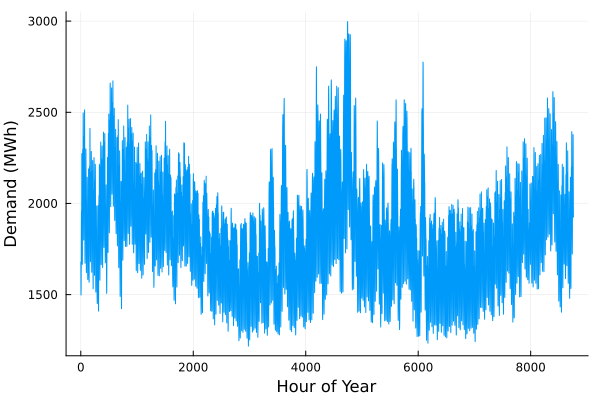

In [3]:
# load the data, pull Zone C, and reformat the DataFrame
NY_demand = DataFrame(CSV.File("data/2013_hourly_load_NY.csv"))
rename!(NY_demand, :"Time Stamp" => :Date)
demand = NY_demand[:, [:Date, :C]]
rename!(demand, :C => :Demand)
demand[:, :Hour] = 1:nrow(demand)

# plot demand
plot(demand.Hour, demand.Demand, xlabel="Hour of Year", ylabel="Demand (MWh)", label=:false)

Next, we load the generator data, shown in
<a href="#tbl-generators" class="quarto-xref">Table 3</a>. This data
includes fixed costs (\$/MW installed), variable costs (\$/MWh
generated), and CO<sub>2</sub> emissions intensity (tCO<sub>2</sub>/MWh
generated).

In [4]:
gens = DataFrame(CSV.File("data/generators.csv"))

Row,Plant,FixedCost,VarCost,Emissions
,String15,Int64,Int64,Float64
1,Geothermal,450000,0,0.0
2,Coal,220000,24,1.0
3,NG CCGT,82000,30,0.43
4,NG CT,65000,40,0.55
5,Wind,91000,0,0.0
6,Solar,70000,0,0.0


Finally, we load the hourly solar and wind capacity factors, which are
plotted in <a href="#fig-cf" class="quarto-xref">Figure 2</a>. These
tell us the fraction of installed capacity which is expected to be
available in a given hour for generation (typically based on the average
meteorology).

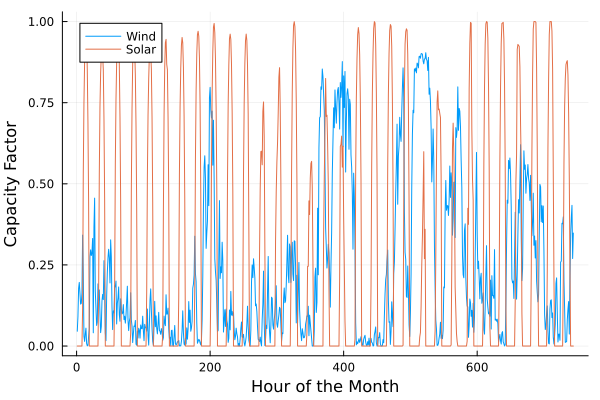

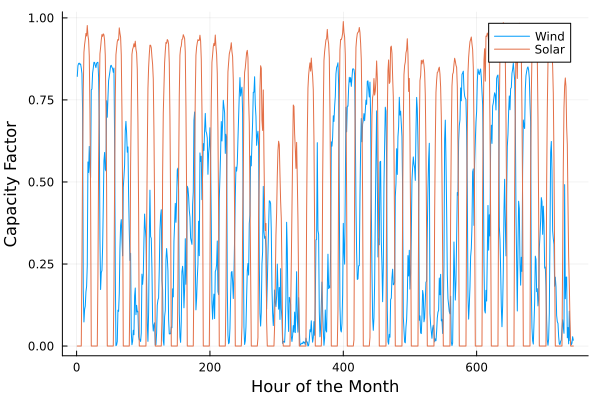

In [5]:
# load capacify factors into a DataFrame
cap_factor = DataFrame(CSV.File("data/wind_solar_capacity_factors.csv"))

# plot January capacity factors
p1 = plot(cap_factor.Wind[1:(24*31)], label="Wind")
plot!(cap_factor.Solar[1:(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

p2 = plot(cap_factor.Wind[4344:4344+(24*31)], label="Wind")
plot!(cap_factor.Solar[4344:4344+(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

display(p1)
display(p2)

You have been asked to develop a generating capacity expansion plan for
the utility in Riley County, NY, which currently has no existing
electrical generation infrastructure. The utility can build any of the
following plant types: geothermal, coal, natural gas combined cycle gas
turbine (CCGT), natural gas combustion turbine (CT), solar, and wind.

While coal, CCGT, and CT plants can generate at their full installed
capacity, geothermal plants operate at maximum 85% capacity, and solar
and wind available capacities vary by the hour depend on the expected
meteorology. The utility will also penalize any non-served demand at a
rate of \$10,000/MWh.

**In this problem**:

-   Formulate a linear program for this capacity expansion problem,
    including clear definitions of decision variable(s) (including
    units), objective function(s), and constraint(s) (make sure to
    explain functions and constraints with any needed derivations and
    explanations).
-   Implement your linear program in `JuMP.jl`. Find the optimal
    solution. How much should the utility build of each type of
    generating plant? What will the total cost be? How much energy will
    be non-served?
-   What fraction of annual generation does each plant type produce? How
    does this compare to the breakdown of built capacity that you found
    in Problem 1.5? Do these results make sense given the generator
    data?
-   Make a plot of the electricity price in each hour. Discuss any
    trends that you see.

> **Significant Digits**
>
> Use `round(x; digits=n)` to report values to the appropriate
> precision! If your number is on a different order of magnitude and you
> want to round to a certain number of significant digits, you can use
> `round(x; sigdigits=n)`.

> **Getting Variable Output Values**
>
> `value.(x)` will report the values of a `JuMP` variable `x`, but it
> will return a special container which holds other information about
> `x` that is useful for `JuMP`. This means that you can’t use this
> output directly for further calculations. To just extract the values,
> use `value.(x).data`.

> **Suppressing Model Command Output**
>
> The output of specifying model components (variable or constraints)
> can be quite large for this problem because of the number of time
> periods. If you end a cell with an `@variable` or `@constraint`
> command, I *highly* recommend suppressing output by adding a
> semi-colon after the last command, or you might find that your
> notebook crashes.



***Explanation***
>The logic of this code is as follows: 
>
>We are trying to minimize the cost of the new energy system, where we have defined cost as:
>Cost=Total Cost of build (Fixed Cost)+Cost to operate (VarCost)+Cost of NSE penalty
>
>We then made a matrix of capacity factors over the course of a year for each type of generator, to help us calculate supply
>
>We set up the variables as each of these three contributers to cost 
>
x=installed capacity (leads to capitcal cost), 
>
y=production for each hour, (leads to operating cost)
>
NSE=Non-served energy amount, (also contributes to operating cost)
>
>The fixed cost was defined as the product of installed capacoty (x) of each generating type and their unique cost/MW to build
>
>The variable cost was defined as a sum of two parts: the operating cost and the NSE penalty
>The operating cost is the product of Variable cost and generated MWh
>
>The NSE penalty is the amount of NSE multiplied by 10000
>
>The constraints on the model were:
>
>Demand+NSE=Suppply
>
>Capacity Factor coulnd't be greater than 1
>
>After that, we make the objective fucntion by calculating the total price as defined originally, using the three variables  
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>



In [80]:
#Set up the sets
Gs=1:(nrow(gens))
Times=1:nrow(demand)
NSEPen=10000

#Make a matrix of CFs for type and time over year
CFs=[0.85*ones(length(Times))';
ones(length(Times))';
ones(length(Times))';
ones(length(Times))';
cap_factor.Wind';
cap_factor.Solar']

#Start the Jump Optimization
CapByGen=Model(HiGHS.Optimizer)

@variables(CapByGen, begin 
x[g in Gs]>=0
y[g in Gs, t in Times]>=0
NSE[t in Times]>=0
end)
@objective(CapByGen, Min,sum(gens[g, :FixedCost] * x[g] for g in G) +
sum(gens[g, :VarCost] * y[g,t] for g in G, t in T) +
NSEPen * sum(NSE[t] for t in T))

@constraint(CapByGen,load[t in T],sum(y[g, t] for g in G) + NSE[t]>=demand.Demand[t])

@constraint(CapByGen, availability[g in G, t in T], y[g, t] <= x[g] * c[g,t])

optimize!(CapByGen)


plant_capacities=[value(x[g]) for g in Gs]
@show plant_capacities

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [5e-05, 1e+00]
  Cost   [2e+01, 4e+05]
  Bound  [0e+00, 0e+00]
  RHS    [1e+03, 3e+03]
Presolving model
56856 rows, 56862 cols, 153048 nonzeros  0s
56853 rows, 56859 cols, 153042 nonzeros  0s
Presolve : Reductions: rows 56853(-4467); columns 56859(-4467); elements 153042(-8934)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.1747e+06) 0s
      42008     6.5458487038e+08 Pr: 0(0); Du: 0(2.07029e-10) 4s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 42008
Objective value     :  6.5458487038e+08
HiGHS run time      :          3.60
plant_capacities = [-0.0, 0.0, 1658.4514133074133, 879.7538120149645, 484.946167110047, 1957.6424239086684]


6-element Vector{Float64}:
   -0.0
    0.0
 1658.4514133074133
  879.7538120149645
  484.946167110047
 1957.6424239086684

From this, we can see that the ***optimal plant capacities*** are: 
Coal=0
Geo=0
CCGT=1658.45 MW
CT=879.75 MW
Wind=484.95 MW
Solar=1957.64 MW


In [87]:
#total energy generated in a year
Total_Supply=[sum(value(y[g, t]) for t in Times) for g in Gs]
Total_Demand=sum(demand.Demand)

generation_fraction = Total_Supply ./ Total_Demand
@show generation_fraction

6-element Vector{Float64}:
 0.0
 0.0
 0.5288793286625715
 0.027454696517380858
 0.08719529308463321
 0.35645499043219436

This shows us that NG CCGT generates the majority of annual energy, with a share of 52.9%, Solar is second with 35.6%, wind has a steeper drop of 8.7%, and lastly is NG CT with a share of 2.7%. Coal and Geothermal produce 0. 

In [88]:
TotalCost=objective_value(CapByGen)
@show TotalCost


6.54584870381541e8

The total cost of building, operating, and paying penaties for NSE is thus 6.54584870*10^6, or 654,584,870 dollars. 

In [89]:
#Total NSE in a year
@show NSE = sum(value(NSE[t]) for t in T)

256.83377442738583

The total amount of MWh not served in a year is 256.83 MWh. 

In [90]:
MWCapBuilt=sum(plant_capacities)

CapFrac=plant_capacities ./ MWCapBuilt

6-element Vector{Float64}:
 -0.0
  0.0
  0.3329692965539611
  0.17662923711651135
  0.09736322863215606
  0.3930382376973714

These results are interesting because we can see a difference between the fractional generation of each generating type and it's fractional capacity. The factor that is controlling the generation is the capacity factor, so it is no suprise that solar accounts for the largest (39%) fraction of total capacity built, though it is second in generation. What may be suprising is the lowest generating fraction, NG CT, accounts for 17.6% of the total built capacity even thoigh it only produces 2.7% of total energy. 

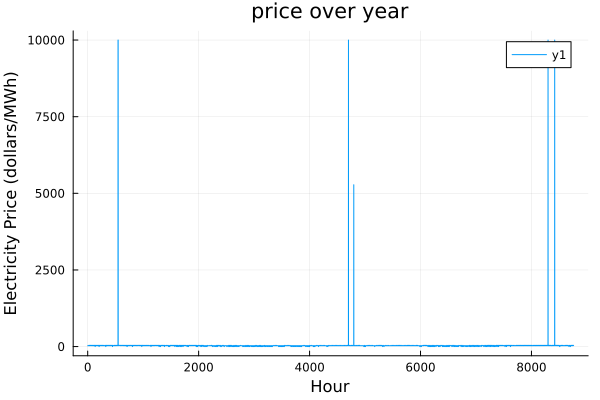

In [93]:
PricesOverYear=abs.([shadow_price(load[t]) for t in Times])
plot(Times, PricesOverYear,xlabel="Hour", ylabel="Electricity Price (dollars/MWh)", title="price over year")

This shows total price of electricity over the year in dollars per MWh, and we can prominently the impact of NSE. Regardless, it was still economically optimal to pay the penalty rather than built the extra capacity. 

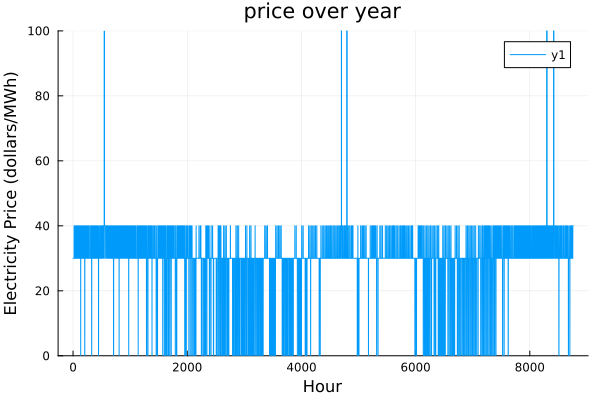

In [94]:
x=Times
y=PricesOverYear
plot(x, y,ylim=(0,100),xlabel="Hour", ylabel="Electricity Price (dollars/MWh)", title="price over year")

Here we just truncated the y axis to 100 dolars/MWh in order to see the flucuations more clearly. We cans ee that cost is generally flucuating between 0 and 40 dolalrs per MWh, and we can also see the impact of sunlight. What we mean by this is prices during the winter months of the year, (the ends of the graph) prices are likely to be higher, likely due to the reduced capacity of solar combined with increased energy demands (from the demand graph)

## References

List any external references consulted, including classmates.